<h1 style="text-align:center">Heavy Equipment Safety using Image Classification</h1>
<h2 style="text-align:center">Gasser Galal Ali</h2>

# Image Cleaning

Images were collected from the internet. They were found using search engines (i.e. Google), and downloaded into the folder `./images`.

The first step is to check the images for duplicated images. This is performed by looping through the files, checking if there are any duplicated hash values, and removing those dupplicates.

In [1]:
import os
import sys
import hashlib

In [2]:
images_folder_path = os.path.abspath('images')
for class_folder_path in [os.path.join(images_folder_path, f) for f in os.listdir(images_folder_path)]:
    print(class_folder_path)
    images = [os.path.join(class_folder_path, f) for f in os.listdir(class_folder_path)]
    repeated = []
    print(f"Found {len(images)} images.")
    for image1_path in images:
        if os.path.exists(image1_path):
            with open(image1_path, 'rb') as image1_data:
                hash1 = hashlib.md5()
                hash1.update(image1_data.read())
                for image2_path in images:
                    if image2_path != image1_path:
                        if os.path.exists(image2_path):
                            with open(image2_path, 'rb') as image2_data:
                                hash2 = hashlib.md5()
                                hash2.update(image2_data.read())
                                if hash1.hexdigest() == hash2.hexdigest():
                                    print(f"Found repeated image {image2_path}.")
                                    repeated.append(image2_path)
    print(f"Found {len(repeated)} repeated images.")
    for image_to_delete in repeated:
        print(f"Deleting {image_to_delete}")
        os.remove(image_to_delete)

C:\Users\ggah4g\Documents\Construction-Equipment-Classifier\images\0
Found 674 images.
Found 0 repeated images.
C:\Users\ggah4g\Documents\Construction-Equipment-Classifier\images\1
Found 944 images.
Found 0 repeated images.


# Data Preparation

In this part, the following steps are performed:
 - Find each image
 - Resize to 100 X 100 Pixels
 - Divide by 255 to normalize
 - Flatten the matrices into vectors
In the end, the `X` matrix containing the inputs, and `y` vector containing the outputs are ready.

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sklearn.preprocessing

In [4]:
images_path = "images"
image_paths = []
for folder_path, dirname, filenames in os.walk("images"):
    if filenames:
        for filename in filenames:
            filepath = os.path.abspath(os.path.join(folder_path, filename))
            image_paths.append(filepath)
print(f"Found {len(image_paths)} images.")

X = []
y = []
for image_path in image_paths:
    try:
        folder_name = os.path.basename(os.path.dirname(image_path))
        image = cv2.imread(image_path)
        image = cv2.resize(image, (100, 100))
        image = image / 255
        image = image.flatten()
        X.append(image)
        if folder_name in ["1"]:
            y.append(1)
        else:
            y.append(0)

    except Exception as e:
        print(e)
        print(f"Skipping {image_path}")

X = np.array(X)
y = np.array(y)

print(f"{np.sum(y)} Images are ready.")
print(f"Dimension of X is {X.shape}")
print(f"Dimension of X is {y.shape}")

Found 1618 images.
944 Images are ready.
Dimension of X is (1618, 30000)
Dimension of X is (1618,)


In [5]:
# Saving
np.save("X", X)
np.save("y", y)

# Check the Data

In this part, an example of the inputs data is shows just to check.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

Image number 778: Has Equipment? 1


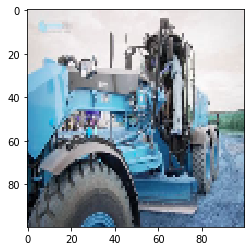

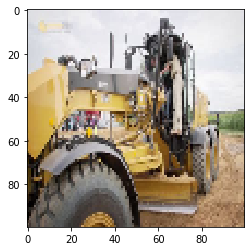

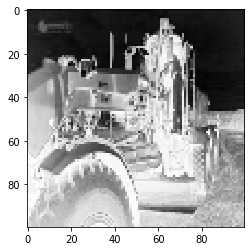

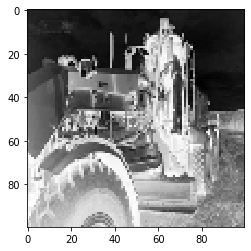

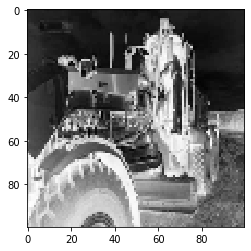

In [7]:
X = np.load("X.npy")
t = np.load("y.npy")
number = np.random.randint(0, len(X))
print(f"Image number {number}: Has Equipment? {t[number]}")
plt.imshow(X[number].reshape((100, 100, 3)))
plt.show()
plt.imshow(np.flip(X[number].reshape((100, 100, 3)), axis=2))
plt.show()
plt.imshow(X[number].reshape((100, 100, 3))[:,:,0], cmap="Greys")
plt.show()
plt.imshow(X[number].reshape((100, 100, 3))[:,:,1], cmap="Greys")
plt.show()
plt.imshow(X[number].reshape((100, 100, 3))[:,:,2], cmap="Greys")
plt.show()

# Train Neural Network using Keras / TensorFlow

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import seaborn as sns
import sklearn.metrics
import pandas as pd
import datetime
from IPython.display import display

[2020-05-04 03:46:02.303019] Training Fold 1 / 5...


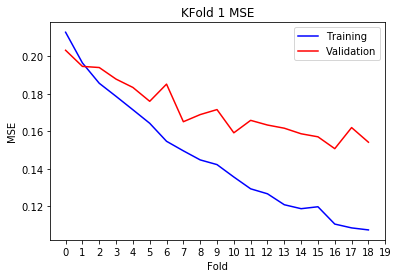

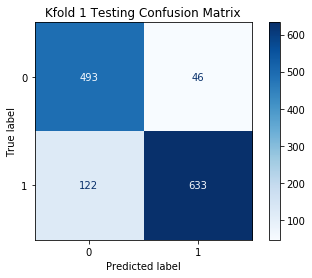

[2020-05-04 03:46:27.301521] Training Fold 2 / 5...


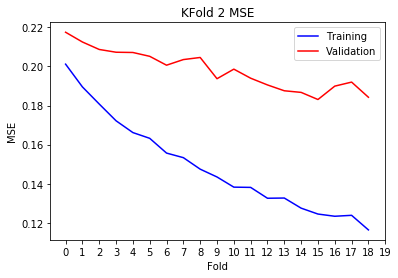

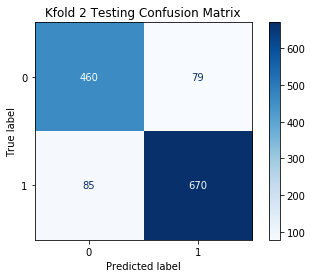

[2020-05-04 03:46:52.334273] Training Fold 3 / 5...


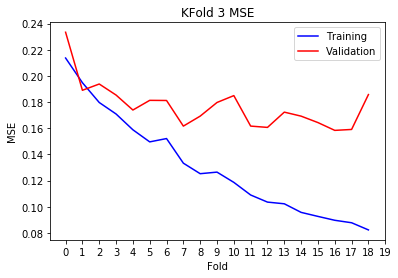

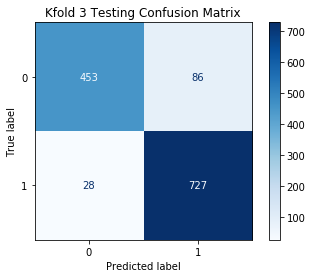

[2020-05-04 03:47:17.132634] Training Fold 4 / 5...


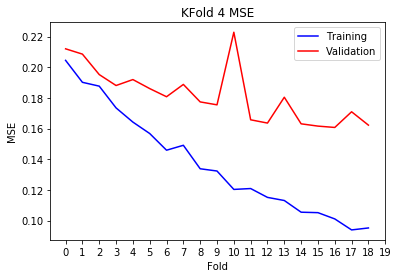

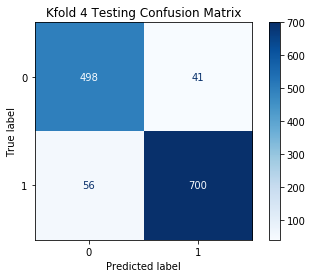

[2020-05-04 03:47:41.807140] Training Fold 5 / 5...


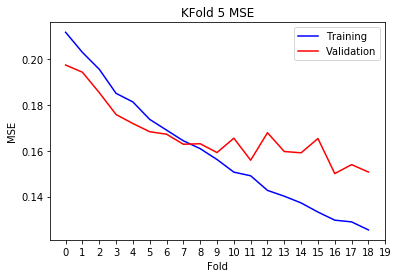

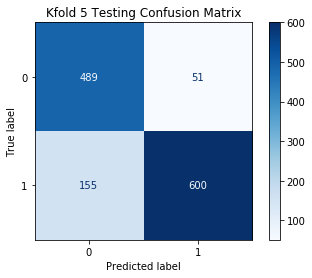

[2020-05-04 03:48:06.746136] Done!


In [9]:
X = np.load("X.npy")
t = np.load("y.npy")

tf.keras.backend.set_floatx('float64')
number_of_folds = 5
kfold_history = {c: [] for c in ['Fold Number', 'Training MSE', 'Testing MSE', 'Training Accuracy', 'Testing Accuracy']}
kf = sklearn.model_selection.StratifiedKFold(number_of_folds, shuffle=True, random_state=1)
for i, (train_index, test_index) in enumerate(kf.split(X, t)):
    number_of_epochs = 20
    print(f"[{datetime.datetime.now()}] Training Fold {i+1} / {number_of_folds}...")
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(5, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss="mse",
        metrics=['acc', 'mse'],
    )
    history = model.fit(
        X[train_index], 
        t[train_index], 
        epochs=number_of_epochs,
        batch_size=10,
        validation_data=(
            X[test_index], 
            t[test_index]
        ),
        verbose=False
    )
    # Calculate Metrics
    pred_test = model.predict_classes(X[test_index])
    pred_traing = model.predict_classes(X[train_index])
    kfold_history['Fold Number'].append(i + 1)
    kfold_history['Training MSE'].append(sklearn.metrics.mean_squared_error(t[train_index], pred_traing))
    kfold_history['Testing MSE'].append(sklearn.metrics.mean_squared_error(t[test_index], pred_test))
    kfold_history['Training Accuracy'].append(sklearn.metrics.accuracy_score(t[train_index], pred_traing))
    kfold_history['Testing Accuracy'].append(sklearn.metrics.accuracy_score(t[test_index], pred_test))
    # Plot the MSEs
    plt.figure()
    plt.plot(history.history['mse'][1:], label="Training", color='blue')
    plt.plot(history.history['val_mse'][1:], label="Validation", color='red')
    plt.xlabel("Fold")
    plt.ylabel("MSE")
    plt.title(f"KFold {i + 1} MSE")
    plt.xticks(list(range(number_of_epochs)))
    plt.legend()
    plt.show()
    # Plot Confusion Matrix
    pred = model.predict_classes(X)
    conf = sklearn.metrics.confusion_matrix(t[train_index], pred_traing)
    sklearn.metrics.ConfusionMatrixDisplay(conf, [0, 1]).plot(cmap='Blues', values_format=".0f")
    plt.title(f"Kfold {i + 1} Testing Confusion Matrix")
    plt.show()
print(f"[{datetime.datetime.now()}] Done!")

In [10]:
kfold_history = pd.DataFrame(kfold_history)
display(kfold_history)
display(kfold_history.describe().T)

,Fold Number,Training MSE,Testing MSE,Training Accuracy,Testing Accuracy
0,1,0.129830,0.216049,0.870170,0.783951
1,2,0.126739,0.243827,0.873261,0.756173
2,3,0.088099,0.200617,0.911901,0.799383
3,4,0.074903,0.207430,0.925097,0.792570
4,5,0.159073,0.216718,0.840927,0.783282


,count,mean,std,min,25%,50%,75%,max
Fold Number,5.0,3.000000,1.581139,1.000000,2.000000,3.000000,4.000000,5.000000
Training MSE,5.0,0.115729,0.034018,0.074903,0.088099,0.126739,0.129830,0.159073
Testing MSE,5.0,0.216928,0.016436,0.200617,0.207430,0.216049,0.216718,0.243827
Training Accuracy,5.0,0.884271,0.034018,0.840927,0.870170,0.873261,0.911901,0.925097
Testing Accuracy,5.0,0.783072,0.016436,0.756173,0.783282,0.783951,0.792570,0.799383


# Train Neural Network using SKlearn

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.neural_network
import sklearn.model_selection
import sklearn.metrics
import seaborn as sns
import copy
import pickle

Fold 1 of 5:


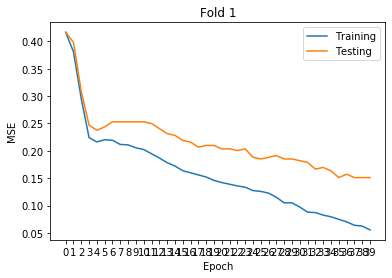

Fold 2 of 5:


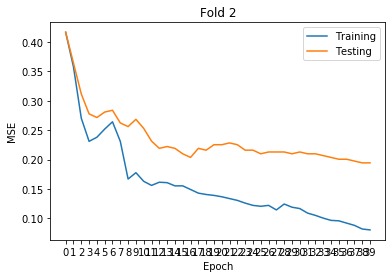

Fold 3 of 5:


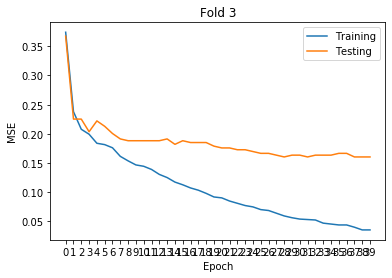

Fold 4 of 5:


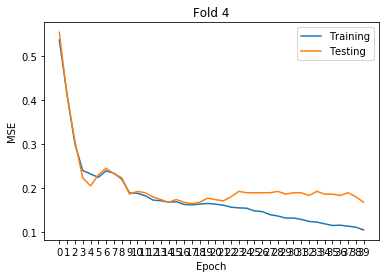

Fold 5 of 5:


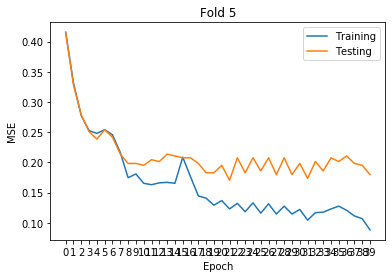

In [12]:
X = np.load("X.npy")
t = np.load("y.npy")

number_of_folds = 5
best_acc = 99999
best_mlp = None
kf = sklearn.model_selection.StratifiedKFold(number_of_folds, shuffle=True, random_state=1)
for fold, (train_index, test_index) in enumerate(kf.split(X, t)):
    print(f"Fold {fold+1} of {number_of_folds}:")
    mlp = sklearn.neural_network.MLPClassifier(
        [100, 50, 50], 
        activation='relu',
        learning_rate='adaptive',
        random_state=1,
        solver='adam',
        learning_rate_init=0.0001,
        tol=0.00001,
        verbose=False
    )
    X_train, t_train = X[train_index], t[train_index]
    X_test, t_test = X[test_index], t[test_index]
    epochs = []
    mse_train = []
    mse_test = []
    for epoch in range(40):
        mlp.partial_fit(
            X_train, 
            t_train, 
            [0, 1]
        )
        """
        for indx in range(0, len(t_test), 200):
            mlp.partial_fit(
                X_train[indx:min(len(t_test), indx + 200)], 
                t_train[indx:min(len(t_test), indx + 200)], 
                [0, 1]
            )
        """
        epochs.append(epoch)
        mse_train.append(np.mean(np.power(t_train - mlp.predict(X_train), 2)))
        mse_test.append(np.mean(np.power(t_test - mlp.predict(X_test), 2)))
    plt.figure()
    plt.plot(epochs, mse_train, label="Training")
    plt.plot(epochs, mse_test, label="Testing")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title(f"Fold {fold + 1}")
    plt.xticks(epochs)
    plt.legend()
    plt.show()

# Train Neural Network in SKlearn using Early Stopping

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.neural_network
import sklearn.model_selection
import sklearn.metrics
import seaborn as sns
import copy
import pickle

In [14]:
X = np.load("X.npy")
t = np.load("y.npy")

number_of_folds = 5
kfold_history = {c: [] for c in ['Fold Number', 'Training MSE', 'Testing MSE', 'Training Accuracy', 'Testing Accuracy']}
kf = sklearn.model_selection.KFold(number_of_folds, shuffle=True, random_state=1)
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"[{datetime.datetime.now()}] Training Fold {i+1} / {number_of_folds} ...")
    mlp = sklearn.neural_network.MLPClassifier(
        [20, 10], 
        activation='relu',
        learning_rate='adaptive',
        random_state=1,
        solver='adam',
        early_stopping=True,
        learning_rate_init=0.0001,
        tol=0.0001,
        verbose=False
    )
    mlp.fit(X[train_index], t[train_index])
    # Calculate Metrics
    pred_test = mlp.predict(X[test_index])
    pred_traing = mlp.predict(X[train_index])
    kfold_history['Fold Number'].append(i + 1)
    kfold_history['Training MSE'].append(sklearn.metrics.mean_squared_error(t[train_index], pred_traing))
    kfold_history['Testing MSE'].append(sklearn.metrics.mean_squared_error(t[test_index], pred_test))
    kfold_history['Training Accuracy'].append(sklearn.metrics.accuracy_score(t[train_index], pred_traing))
    kfold_history['Testing Accuracy'].append(sklearn.metrics.accuracy_score(t[test_index], pred_test))
print(f"[{datetime.datetime.now()}] Done!")

[2020-05-04 03:56:57.617516] Training Fold 1 / 5 ...
[2020-05-04 03:57:28.837931] Training Fold 2 / 5 ...
[2020-05-04 03:57:50.464227] Training Fold 3 / 5 ...
[2020-05-04 03:58:03.261872] Training Fold 4 / 5 ...
[2020-05-04 03:58:25.778483] Training Fold 5 / 5 ...
[2020-05-04 03:58:36.747890] Done!


In [15]:
kfold_history = pd.DataFrame(kfold_history)
display(kfold_history)
display(kfold_history.describe().T)

,Fold Number,Training MSE,Testing MSE,Training Accuracy,Testing Accuracy
0,1,0.170788,0.209877,0.829212,0.790123
1,2,0.220247,0.234568,0.779753,0.765432
2,3,0.297527,0.324074,0.702473,0.675926
3,4,0.201544,0.226006,0.798456,0.773994
4,5,0.245560,0.247678,0.754440,0.752322


,count,mean,std,min,25%,50%,75%,max
Fold Number,5.0,3.000000,1.581139,1.000000,2.000000,3.000000,4.000000,5.000000
Training MSE,5.0,0.227133,0.047885,0.170788,0.201544,0.220247,0.245560,0.297527
Testing MSE,5.0,0.248441,0.044452,0.209877,0.226006,0.234568,0.247678,0.324074
Training Accuracy,5.0,0.772867,0.047885,0.702473,0.754440,0.779753,0.798456,0.829212
Testing Accuracy,5.0,0.751559,0.044452,0.675926,0.752322,0.765432,0.773994,0.790123


# Train a Convolutional Neural Network in Keras / TensorFlow

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [17]:
batch_size = 5
epochs=100
train_datagen = ImageDataGenerator(
    rescale=1/255, 
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

image_size = [100, 100]

train_generator = train_datagen.flow_from_directory(
    './images', 
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    seed=1,
    subset='training',
    shuffle=True,
    )

test_generator = train_datagen.flow_from_directory(
    './images', 
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    seed=1,
    subset='validation',
    shuffle=True,
    )

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=image_size + [3, ]))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=['acc', 'mse'],
)

history = model.fit_generator(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=test_generator.samples // batch_size,
    epochs=epochs,
    verbose=1,
)

Found 1296 images belonging to 2 classes.
Found 322 images belonging to 2 classes.
Epoch 1/100
259/259 [==============================] - 40s 155ms/step - loss: 0.6652 - acc: 0.5972 - mse: 0.2367 - val_loss: 0.6093 - val_acc: 0.5938 - val_mse: 0.2106
Epoch 2/100
259/259 [==============================] - 40s 153ms/step - loss: 0.5846 - acc: 0.7057 - mse: 0.2000 - val_loss: 0.4563 - val_acc: 0.8219 - val_mse: 0.1452
Epoch 3/100
259/259 [==============================] - 40s 153ms/step - loss: 0.5303 - acc: 0.7444 - mse: 0.1771 - val_loss: 0.3606 - val_acc: 0.8719 - val_mse: 0.1064
Epoch 4/100
259/259 [==============================] - 39s 152ms/step - loss: 0.4525 - acc: 0.7932 - mse: 0.1463 - val_loss: 0.2895 - val_acc: 0.9094 - val_mse: 0.0804
Epoch 5/100
259/259 [==============================] - 40s 153ms/step - loss: 0.4192 - acc: 0.8141 - mse: 0.1332 - val_loss: 0.3059 - val_acc: 0.8719 - val_mse: 0.0953
Epoch 6/100
259/259 [==============================] - 39s 152ms/step - loss:

In [26]:
import numpy as np
import sklearn.metrics
X = np.load("X.npy").reshape((X.shape[0], 100, 100, 3))
t = np.load("y.npy")
pred = model.predict_classes(X)
print(f"Accuracy = {sklearn.metrics.accuracy_score(t, pred):.2%}")
print(f"MSE = {sklearn.metrics.mean_squared_error(t, pred):.2f}")

Accuracy = 84.86%
MSE = 0.15


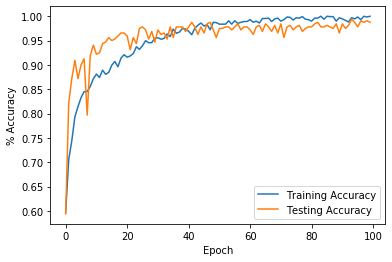

In [19]:
plt.plot(history.history['acc'], label="Training Accuracy")
plt.plot(history.history['val_acc'], label="Testing Accuracy")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("% Accuracy")
plt.show()

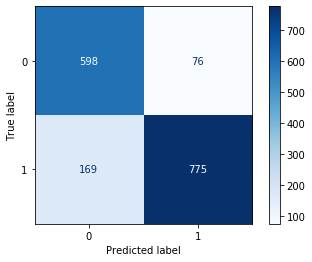

In [20]:
X = np.load("X.npy").reshape((X.shape[0], 100, 100, 3))
t = np.load("y.npy")
# Plot Confusion Matrix
pred = model.predict_classes(X)
conf = sklearn.metrics.confusion_matrix(t, pred )
sklearn.metrics.ConfusionMatrixDisplay(conf, [0, 1]).plot(cmap='Blues', values_format=".0f")
plt.show()

In [25]:
(model.predict(X).round() == model.predict_classes(X)).all()

True